# Add direct diagonalization method to solver and test it

## Original Rabi_oscillations code

In [5]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver, Signal

from qiskit.quantum_info.states import Statevector
from qiskit.quantum_info import DensityMatrix

from qiskit.visualization import plot_bloch_vector
import matplotlib.pyplot as plt

In [3]:
nu_z = 10.
nu_x = 1.
nu_d = 9.98  # Almost on resonance with the Hamiltonian's energy levels difference, nu_z

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')
s_p = 0.5 * (X + 1j * Y)

solver = Solver(static_hamiltonian=.5 * 2 * np.pi * nu_z * Z,
                hamiltonian_operators = [2 * np.pi * nu_x * X],
                hamiltonian_signals = [Signal(envelope=1., carrier_freq=nu_d)])

In [4]:


t_final = .5 / nu_x
tau = .005

y0 = Statevector([1., 0.])

n_steps = int(np.ceil(t_final / tau)) + 1
t_eval = np.linspace(0., t_final, n_steps)

sol = solver.solve(t_span = [0., t_final], y0 = y0, t_eval = t_eval)

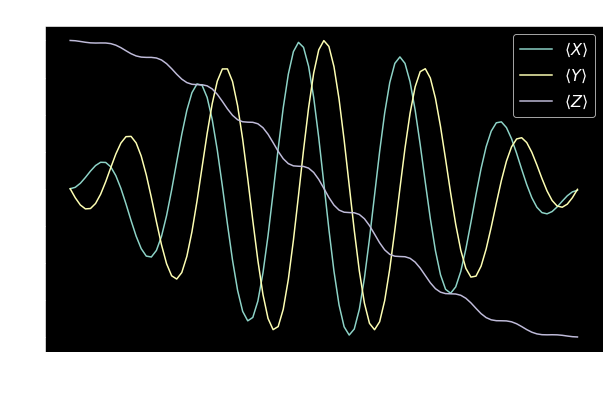

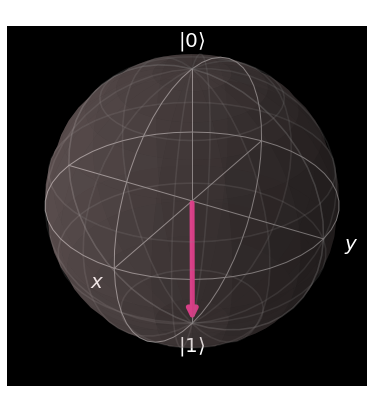

In [6]:

%matplotlib inline

fontsize = 16

def plot_qubit_dynamics(sol, t_eval, X, Y, Z):
    n_times = len(sol.y)
    x_data = np.zeros((n_times,))
    y_data = np.zeros((n_times,))
    z_data = np.zeros((n_times,))

    for t_i, sol_t in enumerate(sol.y):
        x_data[t_i] = sol_t.expectation_value(X).real
        y_data[t_i] = sol_t.expectation_value(Y).real
        z_data[t_i] = sol_t.expectation_value(Z).real

    _, ax = plt.subplots(figsize = (10, 6))
    plt.rcParams.update({'font.size': fontsize})
    plt.plot(t_eval, x_data, label = '$\\langle X \\rangle$')
    plt.plot(t_eval, y_data, label = '$\\langle Y \\rangle$')
    plt.plot(t_eval, z_data, label = '$\\langle Z \\rangle$')
    plt.legend(fontsize = fontsize)
    ax.set_xlabel('$t$', fontsize = fontsize)
    ax.set_title('Bloch vector vs. $t$', fontsize = fontsize)
    plt.show()

    display(plot_bloch_vector([x_data[-1], y_data[-1], z_data[-1]],
                                f'Bloch vector at $t = {t_eval[-1]}$'))

plot_qubit_dynamics(sol, t_eval, X, Y, Z)